In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.constants import c
from interleaver_2_stages import interleaver_2_stage_calc, calculate_spectrum_bandwidth

In [2]:
gf45clo_pdk_sin_neff_ng_variability = pd.read_csv("gf45clo_pdk_sin_neff_ng_variability.csv")
gf45clo_sin_neff_ng_variability = gf45clo_pdk_sin_neff_ng_variability[
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_width']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_height']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_sidewall_angle']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['wg_width (nm)']<1.5)
]

In [3]:
XPS_first_stage_loss_dB   = 0.07
XPS_second_stage_loss_dB  = 0.07
XPS_third_stage_loss_dB   = 0.07
SiN_propagation_loss_dB_m = 40
SiN_directional_coupler_loss_dB = 0.01

SiN_group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
SiN_effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
center_wavelength = 1310e-9
freq = c/(center_wavelength)
FSR_wavelength = 1600e9 * (center_wavelength)**2/(c)
channel_spacing = FSR_wavelength/8
channel1_wavelength = center_wavelength - 3.5*channel_spacing
channel2_wavelength = center_wavelength - 2.5*channel_spacing
channel3_wavelength = center_wavelength - 1.5*channel_spacing
channel4_wavelength = center_wavelength - 0.5*channel_spacing
channel5_wavelength = center_wavelength + 0.5*channel_spacing
channel6_wavelength = center_wavelength + 1.5*channel_spacing
channel7_wavelength = center_wavelength + 2.5*channel_spacing
channel8_wavelength = center_wavelength + 3.5*channel_spacing
channel_wavelength_array = [
    channel1_wavelength,
    channel2_wavelength,
    channel3_wavelength,
    channel4_wavelength,
    channel5_wavelength,
    channel6_wavelength,
    channel7_wavelength,
    channel8_wavelength,
]
dL_1600Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength)
dL_800Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/2)
dL_400Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/4)

optimization_wavelength_sweep = np.linspace(1295e-9,1325e-9,num=4000)
random_variable_sigma = 0.04
cost_function_plot_alpha = 0.3
bounds_epsilon = 5e-3

dL for 400Ghz FSR:  0.00038810533884040785
  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000    0.033016  1.837830  5756.015801
  10    0.495232    0.628152    0.905000    0.031074  1.989120  5665.611027
  20    0.495147    0.630339    0.895303    0.025930  2.467319  5296.029633
  30    0.499560    0.632476    0.895190    0.003600  4.111448  4150.460514
  40    0.501236    0.630439    0.895434    0.000070  4.527225  4157.219523
  50    0.500265    0.632273    0.896100    0.002226  4.347869  4139.275793
  60    0.498555    0.635000    0.895000    0.004244  4.355713  4129.409584
  70    0.499333    0.634974    0.895000    0.003733  4.222925  4130.523835
  80    0.498641    0.634890    0.895041   -0.001347  4.362274  4123.694779
  90    0.498393    0.634698    0.895096   -0.007919  4.253071  4115.205865
 100    0.495758    0.633803    0.895465   -0.042980  4.170717  4077.626442
 110    0.495163    0.630915    0.896425   -0.158506  

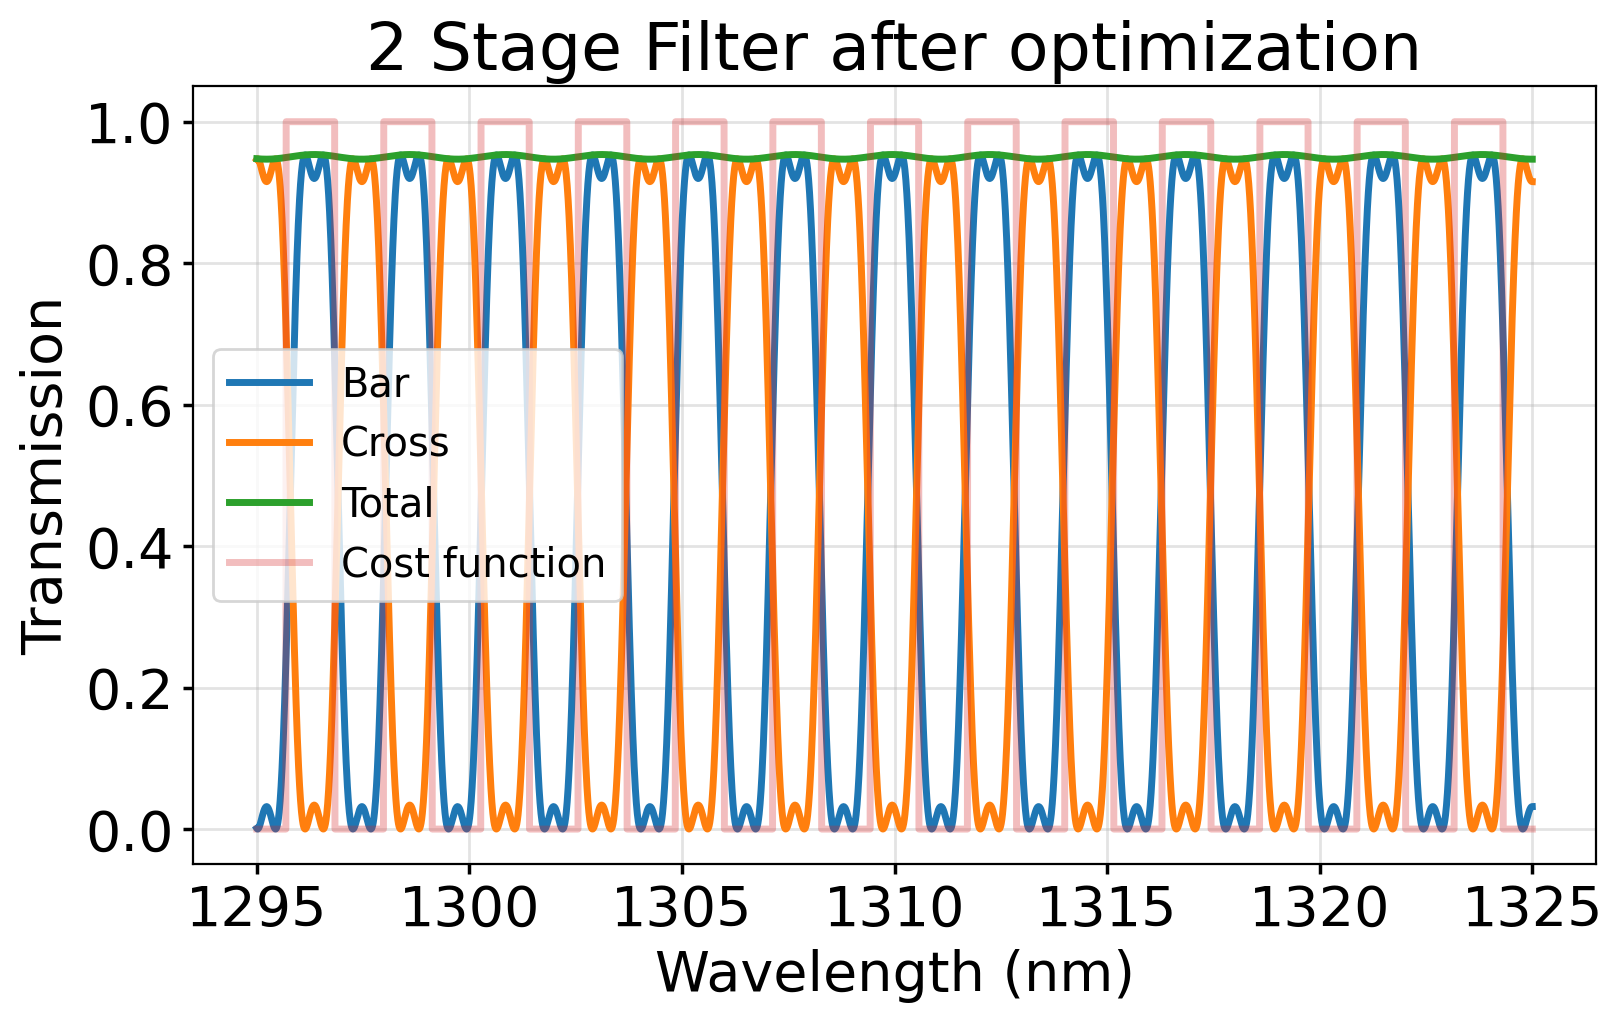

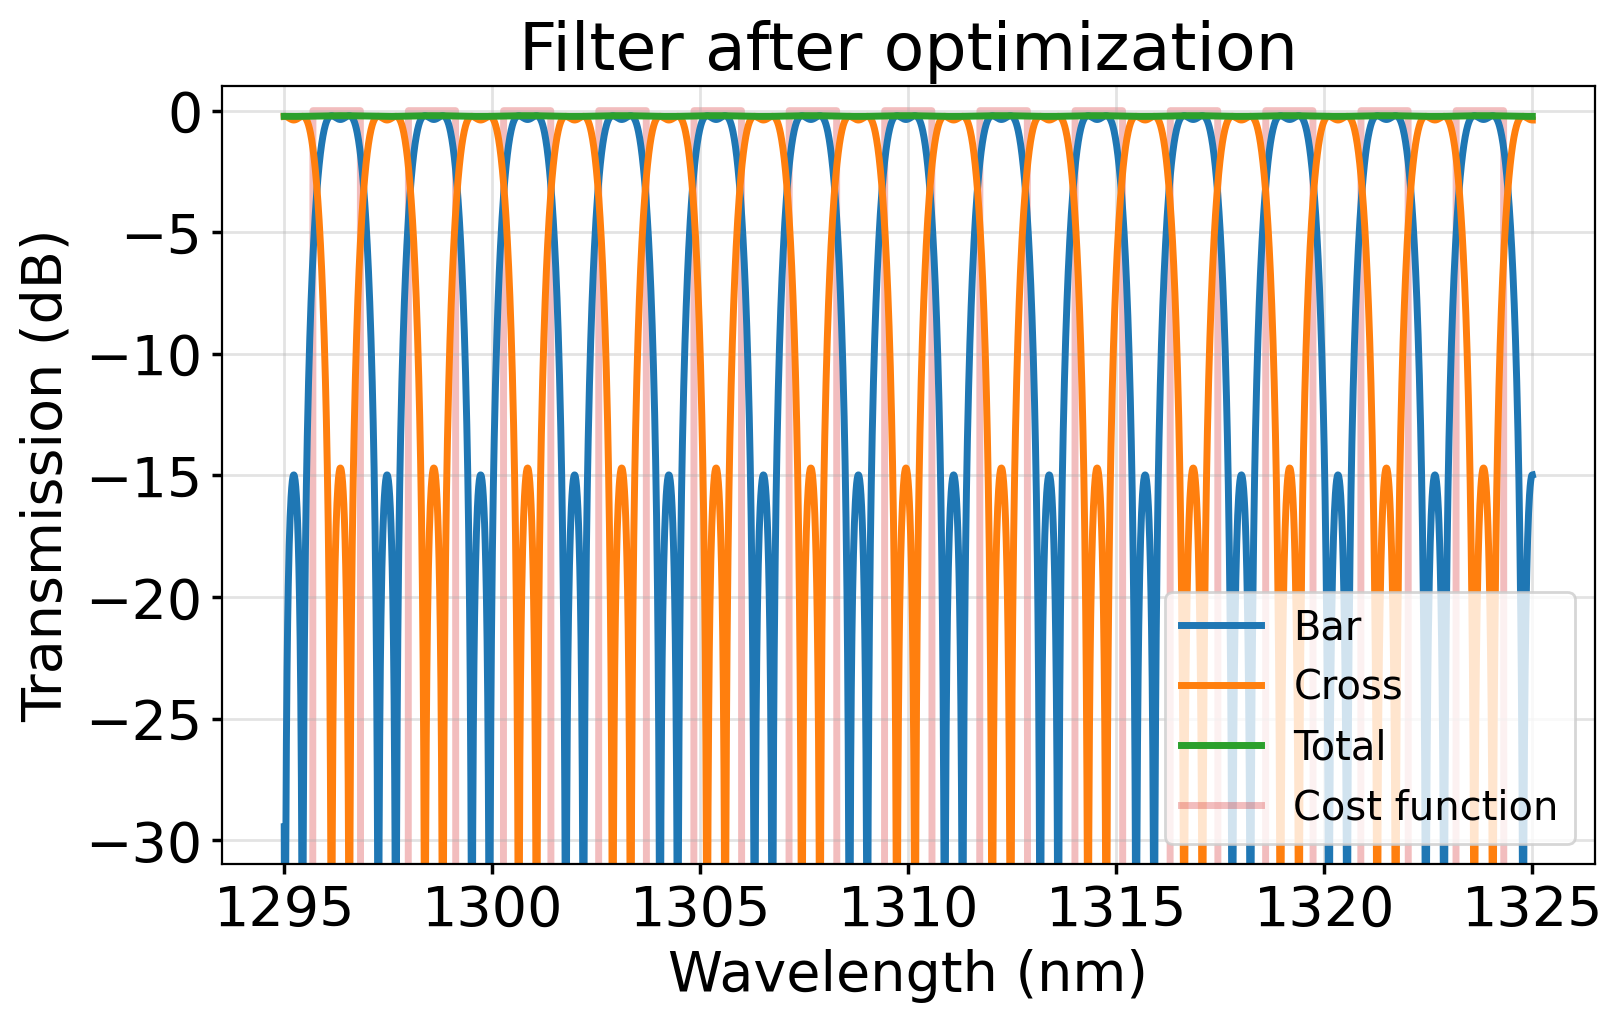

In [4]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3 = 0.9,
    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values),
    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values),
    
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [5]:
num_sweep = len(gf45clo_sin_neff_ng_variability['neff_freq0'].values)

channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9]

random_variable_sigma = [0.02, 0.05, 0.1]
dc_variability = ["common", "differential"]
simulation = ["montecarlo","dc_variability"]

rand_dc1 = {}
rand_dc2 = {}
rand_dc3 = {}

for sigma in random_variable_sigma:
    rand_dc1[sigma] = 1+np.random.normal(0, sigma, num_sweep)
    rand_dc2[sigma] = 1+np.random.normal(0, sigma, num_sweep)
    rand_dc3[sigma] = 1+np.random.normal(0, sigma, num_sweep)

In [6]:
um = 1e-6

interleaver_dataset = {}

idd_interleaver = 1
for sim_mode in simulation:
    for dc_mode in dc_variability:
        for sigma in random_variable_sigma:
            for idd_rand in tqdm(range(num_sweep)):
                interleaver_dc1 = rand_dc1[sigma][idd_rand] * 0.495
                interleaver_dc2 = rand_dc2[sigma][idd_rand] * 0.630
                interleaver_dc3 = rand_dc3[sigma][idd_rand] * 0.895
                if dc_mode == "common":
                    interleaver_dc2 = rand_dc1[sigma][idd_rand] * 0.630 
                    interleaver_dc3 = rand_dc1[sigma][idd_rand] * 0.895

                interleaver_dc1 = np.clip(interleaver_dc1, a_min=0, a_max=1)
                interleaver_dc2 = np.clip(interleaver_dc2, a_min=0, a_max=1)
                interleaver_dc3 = np.clip(interleaver_dc3, a_min=0, a_max=1)
                if sim_mode == "montecarlo":
                    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[idd_rand]
                    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[idd_rand]
                else:
                    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
                    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)

                variation_interleaver = interleaver_2_stage_calc(
                    L=350*um,
                    dL1 = dL_400Ghz_FSR,
                    dL2 = 2*dL_400Ghz_FSR,
                    dc1 = interleaver_dc1,
                    dc2 = interleaver_dc2,
                    dc3 = interleaver_dc3,
                    effective_index = effective_index,
                    group_index = group_index,
                )
                variation_interleaver.channel_spacing = FSR_wavelength/8

                variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]
                variation_interleaver.phase_shift_2_top = interleaver_400Ghz_result.x[4]

                new_dev_params = [
                    interleaver_dc1,
                    interleaver_dc2,
                    interleaver_dc3,
                    interleaver_400Ghz_result.x[3],
                    interleaver_400Ghz_result.x[4],
                ]

                wav, bar_port_amp, cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)
                bar_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)
                cross_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)

                interleaver_dataset[idd_interleaver] = {
                    "wg_width":gf45clo_sin_neff_ng_variability['wg_width (nm)'].values[idd_rand],
                    "wg_height":gf45clo_sin_neff_ng_variability['wg_height (nm)'].values[idd_rand],
                    "wg_sidewall_angle":gf45clo_sin_neff_ng_variability['wg_sidewall_angle (rad)'].values[idd_rand],
                    "neff":effective_index,
                    "ng":group_index,
                    "simulation_mode": sim_mode,
                    "dc_variability_mode":dc_mode,
                    "sigma":sigma,
                    "interleaver_dc1": interleaver_dc1,
                    "interleaver_dc2": interleaver_dc2,
                    "interleaver_dc3": interleaver_dc3,
                    "wav": wav,
                    "bar_port_amp": bar_port_amp,
                    "cross_port_amp": cross_port_amp,
                    "bar_port_fom": bar_port_fom,
                    "cross_port_fom": cross_port_fom
                }

                idd_interleaver += 1

100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [27:55<00:00,  1.12s/it]


In [7]:
gf45clo_pdk_sin_neff_ng_variability = pd.read_csv("gf45clo_pdk_sin_neff_ng_variability.csv")
gf45clo_sin_neff_ng_variability = gf45clo_pdk_sin_neff_ng_variability[
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_width']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_height']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_sidewall_angle']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['wg_width (nm)']>1.5)
]

In [8]:
XPS_first_stage_loss_dB   = 0.07
XPS_second_stage_loss_dB  = 0.07
XPS_third_stage_loss_dB   = 0.07
SiN_propagation_loss_dB_m = 40
SiN_directional_coupler_loss_dB = 0.01

SiN_group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
SiN_effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
center_wavelength = 1310e-9
freq = c/(center_wavelength)
FSR_wavelength = 1600e9 * (center_wavelength)**2/(c)
channel_spacing = FSR_wavelength/8
channel1_wavelength = center_wavelength - 3.5*channel_spacing
channel2_wavelength = center_wavelength - 2.5*channel_spacing
channel3_wavelength = center_wavelength - 1.5*channel_spacing
channel4_wavelength = center_wavelength - 0.5*channel_spacing
channel5_wavelength = center_wavelength + 0.5*channel_spacing
channel6_wavelength = center_wavelength + 1.5*channel_spacing
channel7_wavelength = center_wavelength + 2.5*channel_spacing
channel8_wavelength = center_wavelength + 3.5*channel_spacing
channel_wavelength_array = [
    channel1_wavelength,
    channel2_wavelength,
    channel3_wavelength,
    channel4_wavelength,
    channel5_wavelength,
    channel6_wavelength,
    channel7_wavelength,
    channel8_wavelength,
]
dL_1600Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength)
dL_800Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/2)
dL_400Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/4)

optimization_wavelength_sweep = np.linspace(1295e-9,1325e-9,num=4000)
cost_function_plot_alpha = 0.3
bounds_epsilon = 5e-3

dL for 400Ghz FSR:  0.00038527681460434805
  #      DC1        DC2        DC3       phi1      phi2       Cost
   0    0.500000    0.630000    0.900000   -1.615748  0.475230  5000.171337
  10    0.504480    0.634480    0.896800   -1.571800  0.463255  4931.467298
  20    0.505000    0.631448    0.898751   -0.972459  0.526793  4462.694574
  30    0.501921    0.633178    0.905000    0.552191  0.576958  2874.158590
  40    0.501983    0.630147    0.904710    0.806352  0.614679  2732.410417
  50    0.501557    0.630489    0.904832    0.930304  0.632521  2691.288762
  60    0.502801    0.628653    0.904832    0.941641  0.650195  2672.394765
  70    0.505000    0.625000    0.904828    0.821468  0.707567  2640.313148
  80    0.505000    0.625000    0.905000    0.992180  0.984931  2345.181902
  90    0.504921    0.625000    0.905000    0.923142  1.616593  1791.403259
 100    0.504462    0.625000    0.905000    1.247583  3.196062  1218.364607
 110    0.504526    0.625000    0.905000    1.382640  

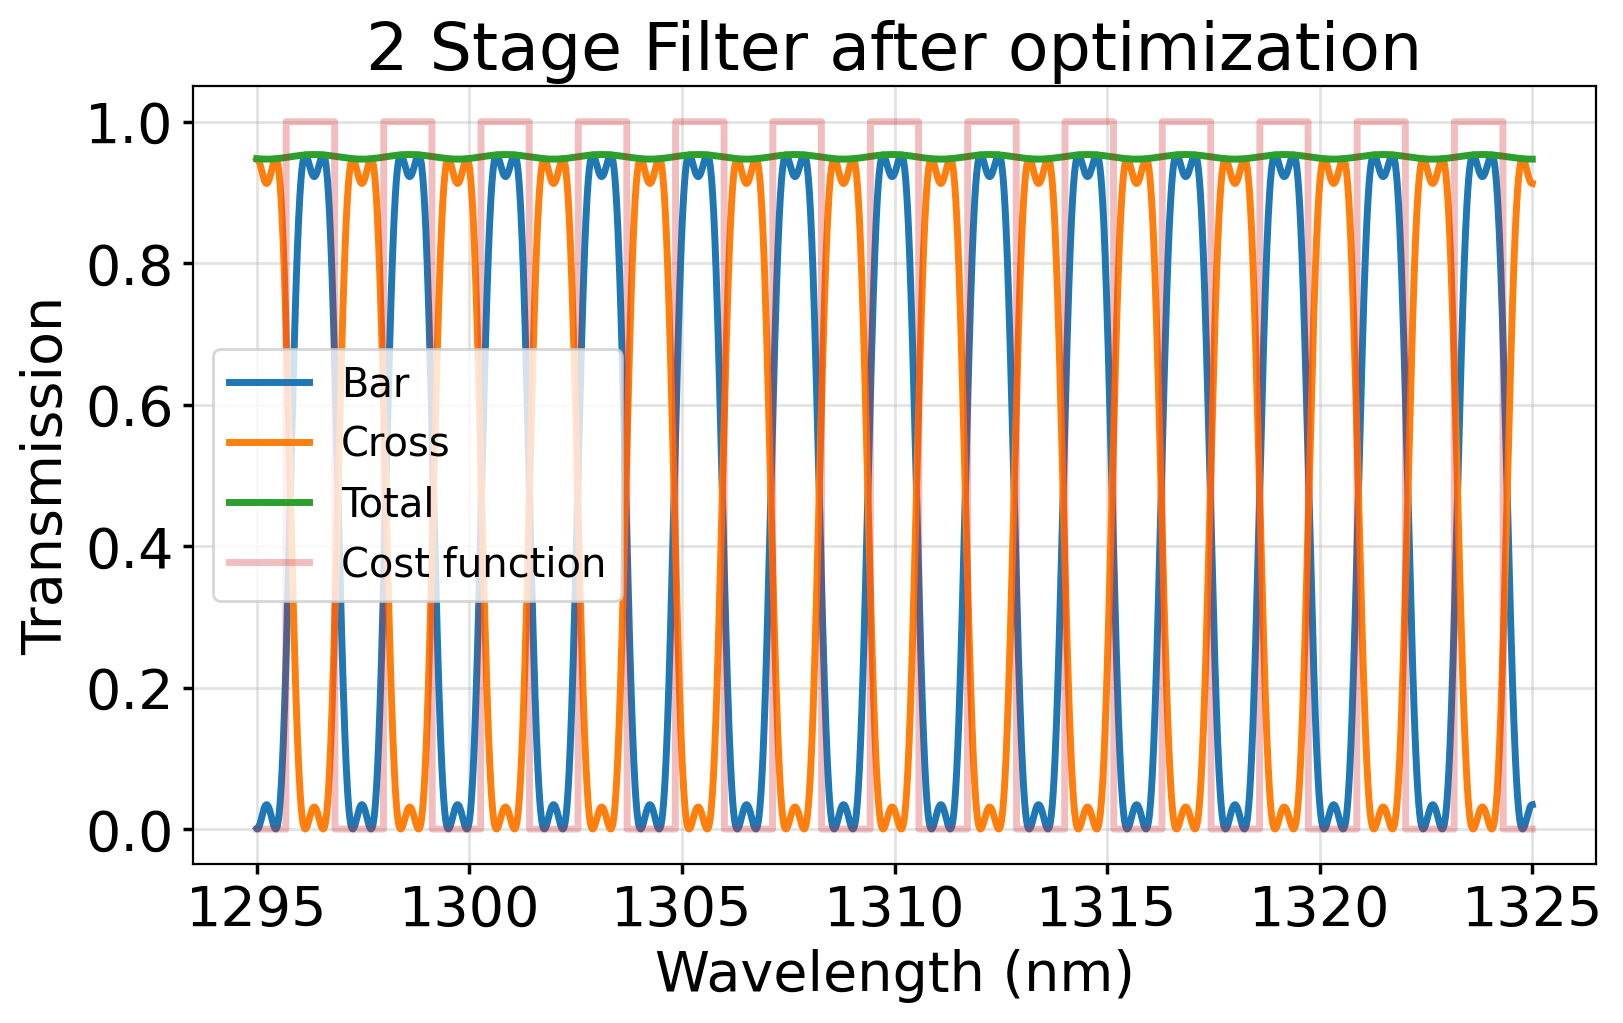

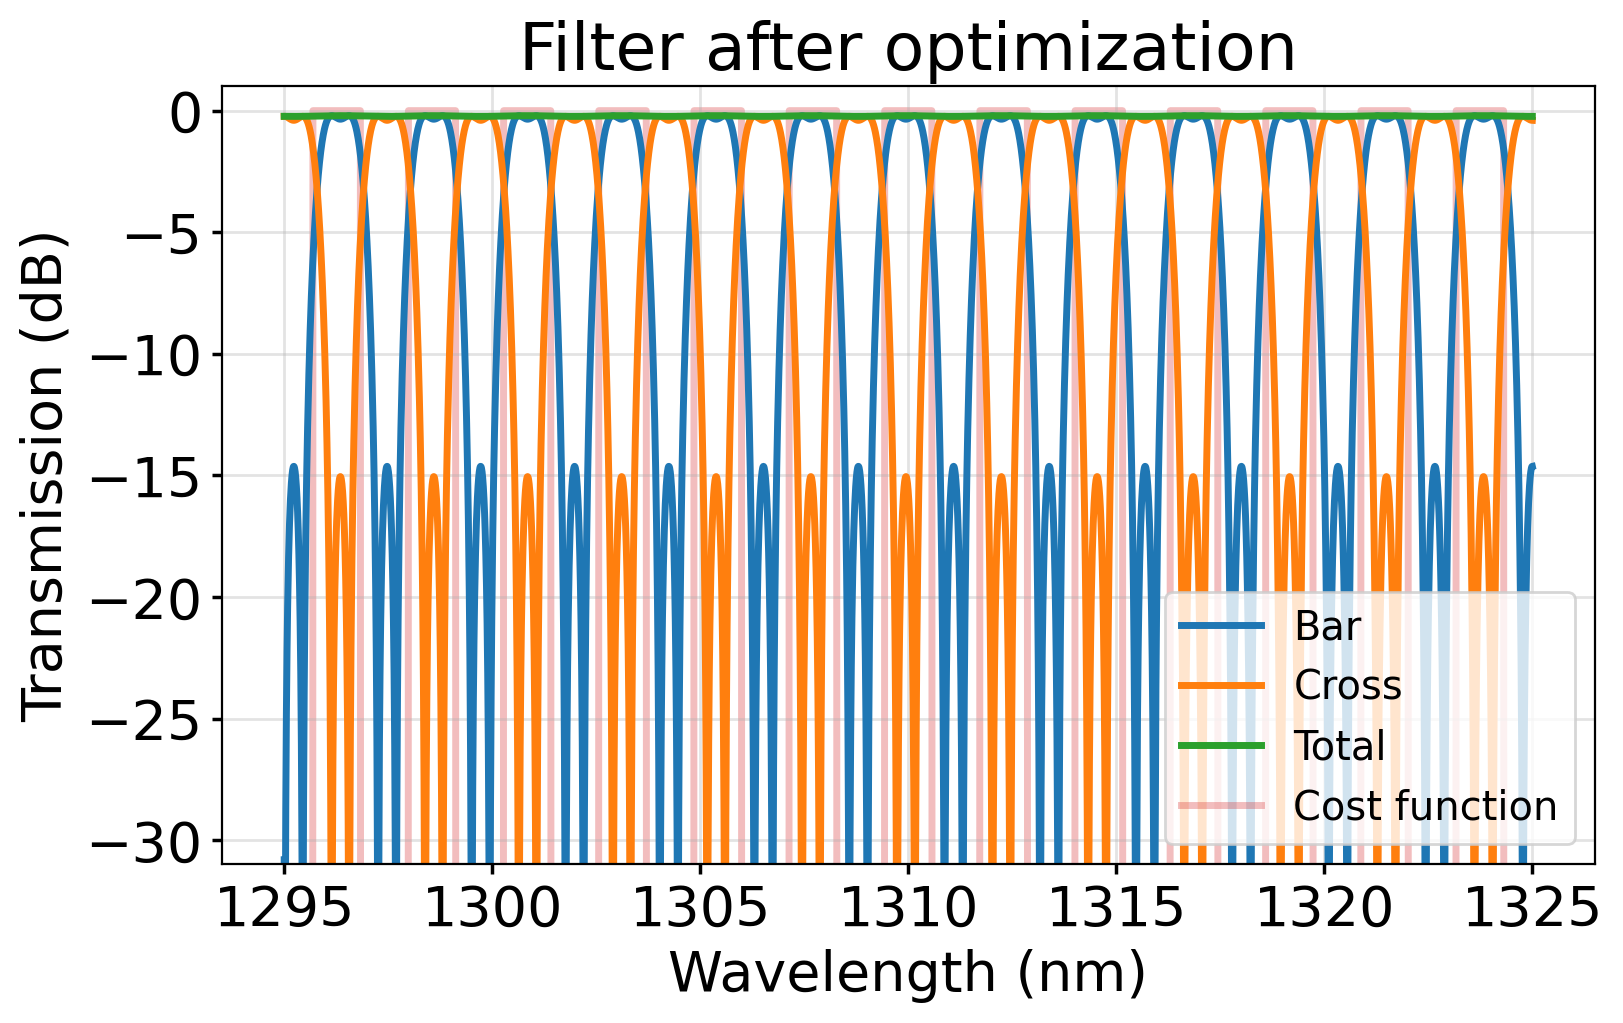

In [9]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_2_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc1 = 0.5,
    dc2 = 0.63,
    dc3 = 0.9,
    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values),
    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values),
    
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [11]:
um = 1e-6

for sim_mode in simulation:
    for dc_mode in dc_variability:
        for sigma in random_variable_sigma:
            for idd_rand in tqdm(range(num_sweep)):
                interleaver_dc1 = rand_dc1[sigma][idd_rand] * 0.495
                interleaver_dc2 = rand_dc2[sigma][idd_rand] * 0.630
                interleaver_dc3 = rand_dc3[sigma][idd_rand] * 0.895
                if dc_mode == "common":
                    interleaver_dc2 = rand_dc1[sigma][idd_rand] * 0.630 
                    interleaver_dc3 = rand_dc1[sigma][idd_rand] * 0.895

                interleaver_dc1 = np.clip(interleaver_dc1, a_min=0, a_max=1)
                interleaver_dc2 = np.clip(interleaver_dc2, a_min=0, a_max=1)
                interleaver_dc3 = np.clip(interleaver_dc3, a_min=0, a_max=1)
                if sim_mode == "montecarlo":
                    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[idd_rand]
                    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[idd_rand]
                else:
                    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
                    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)

                variation_interleaver = interleaver_2_stage_calc(
                    L=350*um,
                    dL1 = dL_400Ghz_FSR,
                    dL2 = 2*dL_400Ghz_FSR,
                    dc1 = interleaver_dc1,
                    dc2 = interleaver_dc2,
                    dc3 = interleaver_dc3,
                    effective_index = effective_index,
                    group_index = group_index,
                )
                variation_interleaver.channel_spacing = FSR_wavelength/8

                variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]
                variation_interleaver.phase_shift_2_top = interleaver_400Ghz_result.x[4]

                new_dev_params = [
                    interleaver_dc1,
                    interleaver_dc2,
                    interleaver_dc3,
                    interleaver_400Ghz_result.x[3],
                    interleaver_400Ghz_result.x[4],
                ]

                wav, bar_port_amp, cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)
                bar_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)
                cross_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)

                interleaver_dataset[idd_interleaver] = {
                    "wg_width":gf45clo_sin_neff_ng_variability['wg_width (nm)'].values[idd_rand],
                    "wg_height":gf45clo_sin_neff_ng_variability['wg_height (nm)'].values[idd_rand],
                    "wg_sidewall_angle":gf45clo_sin_neff_ng_variability['wg_sidewall_angle (rad)'].values[idd_rand],
                    "neff":effective_index,
                    "ng":group_index,
                    "simulation_mode": sim_mode,
                    "dc_variability_mode":dc_mode,
                    "sigma":sigma,
                    "interleaver_dc1": interleaver_dc1,
                    "interleaver_dc2": interleaver_dc2,
                    "interleaver_dc3": interleaver_dc3,
                    "wav": wav,
                    "bar_port_amp": bar_port_amp,
                    "cross_port_amp": cross_port_amp,
                    "bar_port_fom": bar_port_fom,
                    "cross_port_fom": cross_port_fom
                }

                idd_interleaver += 1

100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [29:10<00:00,  1.17s/it]


In [12]:
bar_port_amp_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, len(wav)))
cross_port_amp_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, len(wav)))
bar_port_fom_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, 7, 8))
cross_port_fom_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, 7, 8))

wg_1_params_xr = np.zeros((len(simulation), 5, num_sweep))
wg_2_params_xr = np.zeros((len(simulation), 5, num_sweep))
dc_params_xr = np.zeros((len(simulation),len(random_variable_sigma), 3, num_sweep))

wg_params = ["wg_width","wg_height","wg_sidewall_angle","neff","ng"]
dc_params = ["dc1","dc2", "dc3"]
fom_params = ["1dB_bandwidth","channel_center_frequency","min_dc_il_bandwidth","rf_il_dB","min_dc_il_dB","ave_dc_il_dB","ripple_dc_il_dB"]

for idd_sim_mode, sim_mode in enumerate(simulation):
    for idd_dc_mode, dc_mode in enumerate(dc_variability):
        for idd_sigma_mode,sigma in enumerate(random_variable_sigma):
            for idd_rand, num in enumerate(range(num_sweep)):
                for idd_width, width in enumerate(range(2)):
                    idd_dict = idd_width * len(simulation)*len(dc_variability) * len(random_variable_sigma)*num_sweep + idd_sim_mode * len(dc_variability) * len(random_variable_sigma)* num_sweep + idd_dc_mode*len(random_variable_sigma) * num_sweep + idd_sigma_mode * num_sweep + idd_rand
                    bar_port_amp_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][:] = interleaver_dataset[idd_dict+1]["bar_port_amp"]
                    cross_port_amp_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][:] = interleaver_dataset[idd_dict+1]["cross_port_amp"]
                    
                    for idd_fom, fom_params_name in enumerate(fom_params):
                        bar_port_fom_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][idd_fom][:] = interleaver_dataset[idd_dict+1]["bar_port_fom"][fom_params_name].flatten()
                        cross_port_fom_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][idd_fom][:] = interleaver_dataset[idd_dict+1]["cross_port_fom"][fom_params_name].flatten()
                        
                    if idd_width == 0:
                        for idd_wg_params, wg_params_name in enumerate(wg_params):
                            wg_1_params_xr[idd_sim_mode][idd_wg_params][idd_rand] = interleaver_dataset[idd_dict+1][wg_params_name]
                    elif idd_width == 1:
                        for idd_wg_params, wg_params_name in enumerate(wg_params):
                            wg_2_params_xr[idd_sim_mode][idd_wg_params][idd_rand] = interleaver_dataset[idd_dict+1][wg_params_name]
                            
                for idd_dc_params, dc_params_name in enumerate(dc_params):
                    dc_params_xr[idd_sim_mode][idd_sigma_mode][idd_dc_params][idd_rand] = interleaver_dataset[idd_dict+1]["interleaver_"+dc_params_name]

In [13]:
interleaver_2_stage_dataset = xr.Dataset(
    data_vars = dict(
        bar_port_amp = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand","route_wg", "wavelength"], bar_port_amp_xr),
        cross_port_amp = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand", "route_wg", "wavelength"], cross_port_amp_xr),
        bar_port_fom = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand","route_wg", "fom_params","idd_fom"], bar_port_fom_xr),
        cross_port_fom = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand", "route_wg", "fom_params","idd_fom"], cross_port_fom_xr),
        wg_1 = (["sim_mode","wg_params","idd_rand"], wg_1_params_xr),
        wg_2 = (["sim_mode", "wg_params","idd_rand"], wg_2_params_xr),
        dc = (["sim_mode","dc_sigma", "dc_params","idd_rand"], dc_params_xr)
    ),
    coords = dict(
        sim_mode = simulation,
        dc_variability_mode = dc_variability,
        dc_sigma = random_variable_sigma,
        idd_rand = range(num_sweep),
        route_wg = ["wg_1", "wg_2"],
        wavelength = wav,
        dc_params = dc_params,
        wg_params = wg_params,
        fom_params = fom_params,
        idd_fom = ["ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8"],
        channel_offset = channel_offset_list
    ),
    attrs = dict(description = "Interleaver 2 stage data")
)

In [14]:
interleaver_2_stage_dataset.to_netcdf("interleaver_2_stage_dataset.nc")